<html>
<div>
  <img src="https://www.engineersgarage.com/wp-content/uploads/2021/11/TCH36-01-scaled.jpg" width=360px width=auto style="vertical-align: middle;">
  <span style="font-family: Georgia; font-size:30px; color: white;"> <br/> University of Tehran <br/> AI_CA6 <br/> Spring 02 </span>
</div>
<span style="font-family: Georgia; font-size:15pt; color: white; vertical-align: middle;"> low_mist - std id: 810100186 </span>
</html>

In this notebook we are implement and train a neural network to classify texts.

## Problem Description
in this problem we will learn basics of `Neural Network`. for Part. 1 we train a model for a dataset and classify them and then we pytorch to train a model to help us classifying texts based on their sentiments from a dataset that contains reviews of people about movies.

In [98]:
from __future__ import annotations

# data manipulation
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from abc import ABC, abstractmethod
import math

# data visualization
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plygdata as pg

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# text processing
import re
import nltk as nlt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# types
from dataclasses import dataclass
from enum import Enum
from typing import Union, Iterable, Callable, Optional
from collections import namedtuple, Counter

# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import models, layers, optimizers

## torch
import torch
from torch import nn
from torch.nn import ReLU, Sigmoid, Linear
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import grad

# utils
import os
from tqdm import tqdm
import difflib


In [ ]:
try:
    nlt.data.find('tokenizers/punkt')
except LookupError:
    nlt.download('punkt')
try:
    nlt.data.find('tokenizers/stopwords')
except LookupError:
    nlt.download('stopwords')
try:
    nlt.data.find('tokenizers/wordnet')
except LookupError:
    nlt.download('wordnet')


stopwords = set(stopwords.words('english'))

## Part 1. MLP from scratch

We will code a [FNN](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiq2ue-qJP_AhVJgP0HHdbtCk8QFnoECAoQAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FFeedforward_neural_network&usg=AOvVaw3rDG-BPMXT8xxLxhU6yJlG) (i.e. Feed Forward Neural Network) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check out `torch.clamp`, `torch.nn.Parameter`

Let's first take a look at the data.

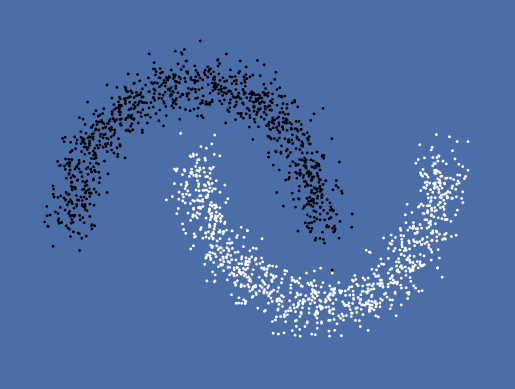

In [7]:
X, Y = None, None
x_min, x_max = -1.5, 2.5
y_min, y_max = -1  , 1.5

def create_X_Y(mode: str = "moon"):
    global X, Y
    global x_min, x_max
    global y_min, y_max
    
    if mode == "moon":
        X, Y = make_moons(n_samples=2000, noise=0.1)
        
    elif mode == "circle":
        X, Y = make_circles(n_samples=2000, noise=0.1)
        x_min, x_max = -1.5, 1.5
        y_min, y_max = -1.5, 1.5
        
    elif mode == "classification":
        X, Y = make_classification(n_samples=2000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0)
        x_min, x_max = -7, 7
        y_min, y_max = -4, 4
        
    elif mode == "spiral":
        data_array = np.array(pg.generate_data(pg.DatasetType.ClassifySpiralData, 0.0))
        X = data_array[:,:-1]
        Y = data_array[:,-1]
        Y = (Y + 1)/2
        x_min, x_max = X.min() - 2, X.max() + 2
        y_min, y_max = Y.min() - 5, Y.max() + 4


create_X_Y()

fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

%matplotlib inline
def plot_data(ax: Axes, X: NDArray, Y: NDArray):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')
plot_data(ax, X, Y)
plt.show()


In [186]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))


def plot_decision_boundary(
    ax: Axes,
    X: NDArray,
    Y: NDArray,
    classifier: Union["Sequential", "MyLinear", "MySigmoid", "MyReLU"],
):
    Z = classifier.forward(to_forward.T)
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z > 0.5, cmap="Blues")

    plot_data(ax, X, Y)

Implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation.

## ReLU (Rectified Linear Unit)

The ReLU activation function is defined as:

$$
f(x) = max(0, x)
$$

where $x$ is the input to the function.

### Forward Pass

During the forward pass, the ReLU function simply returns the input value if it is positive, and returns 0 if it is negative. Mathematically, this can be expressed as:

$$
f(x) = \begin{cases}
x & \text{if } x >= 0 \\
0 & \text{otherwise}
\end{cases}
$$

### Backward Pass

During the backward pass, the gradient of the loss function with respect to the input is computed using the chain rule. If the input is positive, the gradient is simply 1, since the output of the ReLU function is equal to the input. If the input is negative, the gradient is 0, since the output of the ReLU function is 0. Mathematically, this can be expressed as:

$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial f} \frac{\partial f}{\partial x} 
= \begin{cases}
\frac{\partial L}{\partial x} & \text{ if } x > 0 \\ 
0 & \text{otherwise}
\end{cases}
$$

where $\frac{\partial L}{\partial x}$ is the gradient of the loss function with respect to the input, $\frac{\partial L}{\partial f}$ is the gradient of the loss function with respect to the output of the ReLU function, and $\frac{\partial f}{\partial x}$ is the derivative of the ReLU function with respect to the input.

## Sigmoid

The sigmoid activation function is defined as:

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

where $x$ is the input to the function and $e$ is the exponential function.

### Forward Pass

During the forward pass, the sigmoid function returns a value between 0 and 1 for any input. Mathematically, this can be expressed as:

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

### Backward Pass

During the backward pass, the gradient of the loss function with respect to the input is computed using the chain rule. The gradient of the sigmoid function with respect to the input is given by:

$$
\frac{\partial f}{\partial x} = f(x) (1 - f(x))
$$

where $f(x)$ is the output of the function. The gradient of the loss function with respect to the output of the sigmoid function is then multiplied by the gradient of the sigmoid function with respect to the input to obtain the gradient of the loss function with respect to the input. Mathematically, this can be expressed as:

$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial f} \frac{\partial f}{\partial x} = \frac{\partial L}{\partial f} f(x) (1 - f(x))
$$

where $\frac{\partial L}{\partial x}$ is the gradient of the loss function with respect to the input, $\frac{\partial L}{\partial f}$ is the gradient of the loss function with respect to the output of the sigmoid function, and $\frac{\partial f}{\partial x}$ is the derivative of the sigmoid function with respect to the input.

In [8]:
class MyReLU(object):
    def forward(self, x) -> NDArray:
        self.relu = np.maximum(0, x)
        return self.relu

    def backward(self, grad_output) -> NDArray:
        return np.where(self.relu > 0, grad_output, 0)

    def step(self, learning_rate):
        pass


class MySigmoid(object):
    def forward(self, x) -> NDArray:
        x = np.clip(x, -1000, 1000)
        self.sigmoid = np.reciprocal(1 + np.exp(-x))
        return self.sigmoid

    def backward(self, grad_output) -> NDArray:
        return grad_output * self.sigmoid * (1 - self.sigmoid)

    def step(self, learning_rate):
        pass

In [188]:
x = np.array([0, -1, 0.5, -0.5, 0.8, 1])
grad_output = np.ones_like(x)
x_torch = torch.tensor(x, requires_grad=True)
grad_output_torch = torch.tensor(grad_output)

my_relu = MyReLU()

torch_relu = ReLU()

my_relu_output = my_relu.forward(x)
my_relu_grad_input = my_relu.backward(grad_output)

torch_relu_output = torch_relu(x_torch)
torch_relu_output.backward(grad_output_torch)
torch_relu_grad_input = x_torch.grad.numpy()

print("MyReLU grad_input:", my_relu_grad_input)
print("PyTorch ReLU grad_input:", torch_relu_grad_input)
print("MyReLU output:", my_relu_output)
print("PyTorch ReLU output:", torch_relu_output)

MyReLU grad_input: [0. 0. 1. 0. 1. 1.]
PyTorch ReLU grad_input: [0. 0. 1. 0. 1. 1.]
MyReLU output: [0.  0.  0.5 0.  0.8 1. ]
PyTorch ReLU output: tensor([0.0000, 0.0000, 0.5000, 0.0000, 0.8000, 1.0000], dtype=torch.float64,
       grad_fn=<ReluBackward0>)


In [189]:
my_sigmoid = MySigmoid()
torch_sigmoid = Sigmoid()

my_sigmoid_output = my_sigmoid.forward(x)
my_sigmoid_grad_input = my_sigmoid.backward(grad_output)

torch_sigmoid_output = torch_sigmoid(x_torch)
torch_sigmoid_output.backward(grad_output_torch)
torch_sigmoid_grad_input = x_torch.grad.numpy()

print("MySigmoid output:", my_sigmoid_output)
print("PyTorch Sigmoid output:", torch_sigmoid_output)
print("MySigmoid grad_input:", my_sigmoid_grad_input)
print("PyTorch Sigmoid grad_input:", torch_sigmoid_grad_input)

MySigmoid output: [0.5        0.26894142 0.62245933 0.37754067 0.68997448 0.73105858]
PyTorch Sigmoid output: tensor([0.5000, 0.2689, 0.6225, 0.3775, 0.6900, 0.7311], dtype=torch.float64,
       grad_fn=<SigmoidBackward0>)
MySigmoid grad_input: [0.25       0.19661193 0.23500371 0.23500371 0.2139097  0.19661193]
PyTorch Sigmoid grad_input: [0.25       0.19661193 1.23500371 0.23500371 1.2139097  1.19661193]


### Linear Layer

A linear layer, also known as a fully connected layer, is a type of layer in a neural network that connects every neuron in one layer to every neuron in the next layer. It is called a linear layer because it performs a linear transformation on the input data.

The linear layer can be represented mathematically as:

$$y = Wx + b$$

where $x$ is the input data, $W$ is the weight matrix, $b$ is the bias vector, and $y$ is the output of the linear layer.

During forward propagation, the input data is multiplied by the weight matrix and the bias vector is added to the result. The output of the linear layer is then passed through an activation function, such as ReLU or sigmoid, to introduce non-linearity into the network.

The weight matrix $W$ contains the learnable parameters of the layer, which are updated during training to minimize the loss function. The bias vector $b$ is added to the output of the weight matrix to introduce a shift in the output.

During backpropagation, the gradients of the loss function with respect to the weight matrix and bias vector are computed and used to update the parameters of the layer.

The linear layer is typically used in the early layers of a neural network, where the input data is transformed into a higher-dimensional space. This transformation allows the neural network to learn more complex features of the input data.

$$
y_i = \sum_j W_{i,j} x_j + b_i
$$

$$
\frac{\partial y_i}{\partial W_{i,j}} = x_j
$$

$$
\frac{\partial \text{loss}}{\partial y_i} = \text{grad\_output}[i]
$$

By the chain rule:

$$
\frac{\partial \text{loss}}{\partial W_{i,j}} = x_j \cdot \text{grad\_output}[i]
$$

$$
\frac{\partial \text{loss}}{\partial x_j} = \sum_i \left(\frac{\partial \text{loss}}{\partial y_i}\right) \left(\frac{\partial y_i}{\partial x_j}\right)
$$



In [9]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        self.W = np.random.randn(n_output, n_input)
        self.b = np.random.randn(n_output, 1)

    def forward(self, x: NDArray):
        self.x = x
        return self.W @ x + self.b

    def backward(self, grad_output):
        self.dW = grad_output @ self.x.T
        self.db = np.sum(grad_output, axis=1, keepdims=True)
        grad_input = self.W.T @ grad_output
        return grad_input

    def step(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db

### Sequential 
We will now design out NN. Note that with a Sigmoid layer, you should use the BCE loss.  

BCE loss stands for Binary Cross-Entropy loss. It is a loss function used for binary classification problems, where the goal is to predict one of two possible classes. BCE loss measures the dissimilarity between the true class labels and the predicted probabilities of the positive class.

In PyTorch, BCE loss can be computed using the `BCELoss` class. This class creates a criterion that measures the binary cross-entropy between the target and the input probabilities. The formula for BCE loss is:

$$
\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - w_n \left [ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]
$$

where $N$ is the batch size, $x$ is the input probabilities, $y$ is the target, and $w$ is an optional weight tensor that can be used to rescale the loss of each batch element.

#### SGD
**Stochastic Gradient Descent (SGD)** is an iterative method for optimizing an objective function with suitable smoothness properties (e.g. differentiable or subdifferentiable). It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data).

In high-dimensional optimization problems, this reduces the computational burden, achieving faster iterations in exchange for a lower convergence rate. SGD is commonly used in training deep learning models.

In [10]:
class Sequential(object):
    def __init__(self):
        self.layers: list[Union[MyLinear, MyReLU, MySigmoid]]
        self.reset()

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, x):
        current = x
        for layer in self.layers:
            current = layer.forward(current)
        return current

    def compute_loss(self, out, label):
        eps = 1e-10
        if out == 0:
            out += eps
        elif out == 1:
            out -= eps
        loss = -(label * np.log(out) + (1 - label) * np.log(1 - out))
        self.grad_output = (out - label) / (out * (1 - out))
        return loss

    def backward(self):
        current = self.grad_output
        for layer in reversed(self.layers):
            current = layer.backward(current)

    def step(self, learning_rate):
        for layer in self.layers:
            layer.step(learning_rate)
            
    def reset(self):
        self.layers = []

Now we check our NN with multiple datasets.

In [192]:
my_model = Sequential()
my_model.add_layer(MyLinear(n_input=2, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=1))
my_model.add_layer(MySigmoid())

In [193]:
losses = []
learning_rate = 1e-2
epochs = 10
for epoch in range(epochs):
    loss_sum = 0 
    for it in range(len(X)):
        idx = np.random.randint(0, len(X))
        x = X[idx]
        x = x.reshape(2, 1)
        label = Y[idx]
        out = my_model.forward(x)
        loss_sum += my_model.compute_loss(out, label)
        my_model.backward()
        my_model.step(learning_rate)
    losses.append(loss_sum / len(X))

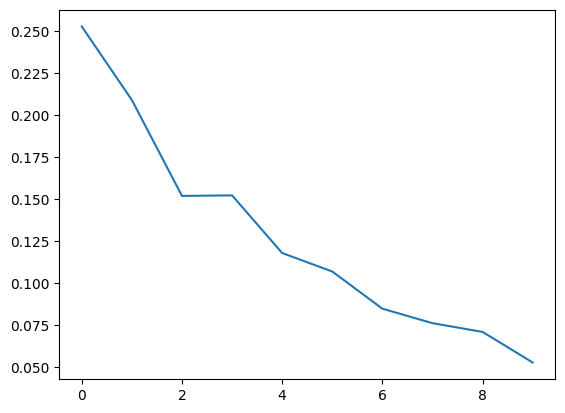

In [194]:
losses = np.array(losses)
losses = losses.reshape((-1, 1))
%matplotlib inline
plt.plot(losses)
plt.show()

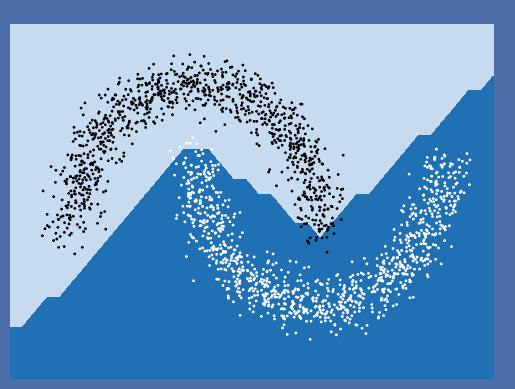

In [195]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, my_model)
fig.canvas.draw()

### Circle dataset

In [196]:
create_X_Y("circle")

my_model = Sequential()
my_model.add_layer(MyLinear(n_input=2, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MySigmoid())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MySigmoid())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MySigmoid())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=1))
my_model.add_layer(MySigmoid())

losses = []
learning_rate = 1e-2
epochs = 200
for epoch in range(epochs):
    loss_sum = 0
    for it in range(len(X)):
        idx = np.random.randint(0, len(X))
        x = X[idx]
        x = x.reshape(2, 1)
        label = Y[idx]
        out = my_model.forward(x)
        loss_sum += my_model.compute_loss(out, label)
        my_model.backward()
        my_model.step(learning_rate)
    losses.append(loss_sum / len(X))

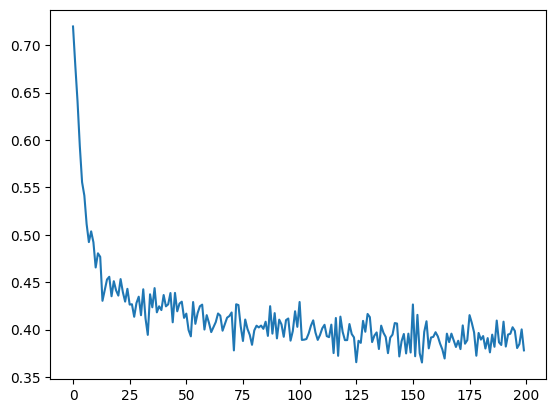

In [197]:
losses = np.array(losses)
losses = losses.reshape((-1, 1))
%matplotlib inline
plt.plot(losses)
plt.show()

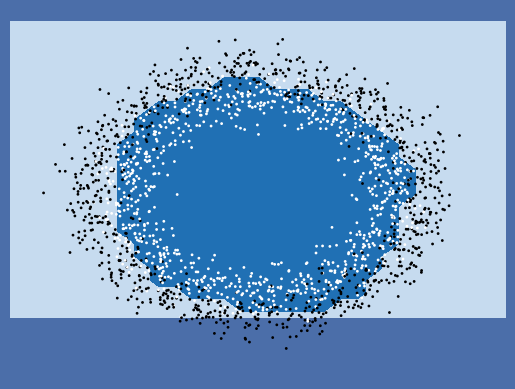

In [198]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, my_model)
fig.canvas.draw()

### Classification dataset

In [199]:
create_X_Y("classification")

my_model = Sequential()
my_model.add_layer(MyLinear(n_input=2, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MySigmoid())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MySigmoid())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MySigmoid())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MySigmoid())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=1))
my_model.add_layer(MySigmoid())

losses = []
learning_rate = 1e-2
epochs = 300
for epoch in range(epochs):
    loss_sum = 0
    for it in range(len(X)):
        idx = np.random.randint(0, len(X))
        x = X[idx]
        x = x.reshape(2, 1)
        label = Y[idx]
        out = my_model.forward(x)
        loss_sum += my_model.compute_loss(out, label)
        my_model.backward()
        my_model.step(learning_rate)
    losses.append(loss_sum / len(X))

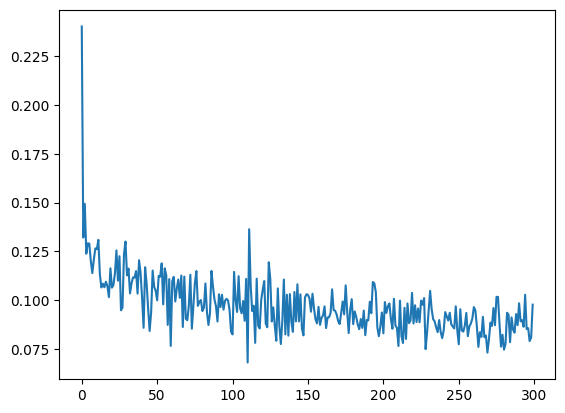

In [200]:
losses = np.array(losses)
losses = losses.reshape((-1, 1))
%matplotlib inline
plt.plot(losses)
plt.show()

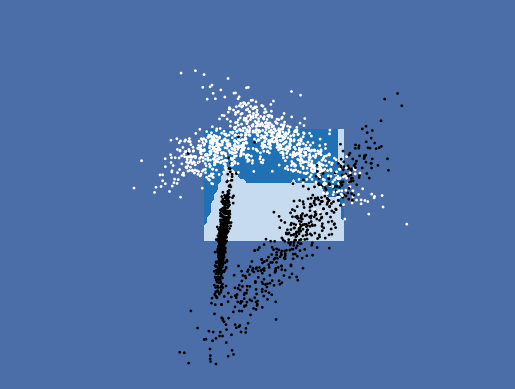

In [201]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, my_model)
fig.canvas.draw()

### Spiral dataset

In [202]:
create_X_Y("spiral")

my_model = Sequential()
my_model.add_layer(MyLinear(n_input=2, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MySigmoid())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MySigmoid())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MySigmoid())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MySigmoid())
my_model.add_layer(MyLinear(n_input=10, n_output=10))
my_model.add_layer(MyReLU())
my_model.add_layer(MyLinear(n_input=10, n_output=1))
my_model.add_layer(MySigmoid())

losses = []
learning_rate = 1e-2
epochs = 400
for epoch in range(epochs):
    loss_sum = 0 
    for it in range(len(X)):
        idx = np.random.randint(0, len(X))
        x = X[idx]
        x = x.reshape(2, 1)
        label = Y[idx]
        out = my_model.forward(x)
        loss_sum += my_model.compute_loss(out, label)
        my_model.backward()
        my_model.step(learning_rate)
    losses.append(loss_sum / len(X))

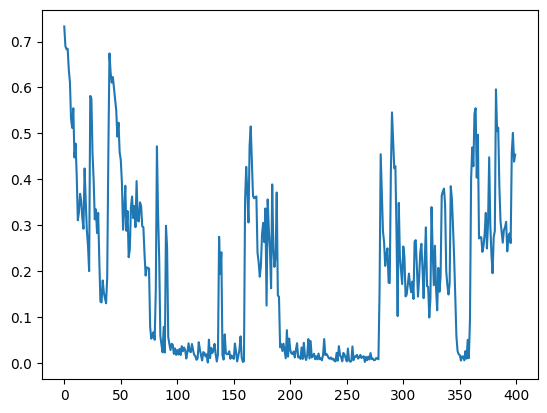

In [203]:
losses = np.array(losses)
losses = losses.reshape((-1, 1))
%matplotlib inline
plt.plot(losses)
plt.show()

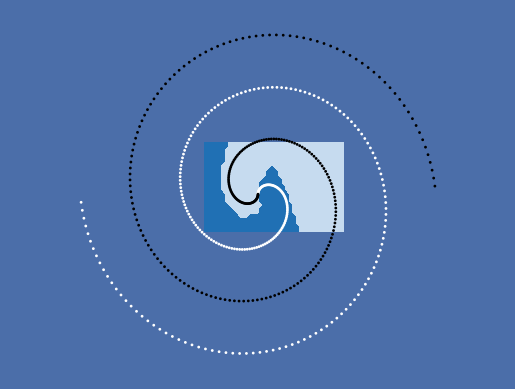

In [204]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, my_model)
fig.canvas.draw()

## Part 2. Using a Pytorch module

In this last part, we use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

## 3.1. Load & Preprocess the IMDB Dataset

In this section, you are required to read and load the provided `csv` file, and perform the preprocessing steps as specified in the assignment's description.

## Dataset
The `imdb_dataset.csv` file contains data about around 50000 people reviews from [imdb](https://imdb.com) and their sentiments. The dataset was gathered from [this link](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [119]:
tqdm.pandas()
df = pd.read_csv("assets/data/imdb_dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


First let's visualize our data frame.

In [120]:
df.shape

(50000, 2)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


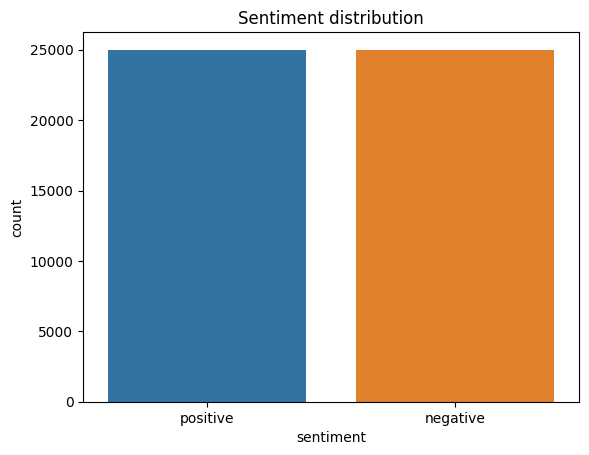

In [122]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment distribution")
plt.show()

Now lets's see some of the reviews

In [123]:
for _ in range(5):
    i = np.random.randint(0, len(df))
    print("Review:", i)
    print(df['review'].iloc[i])
    print("Sentiment:", df['sentiment'].iloc[i], "\n----------------------------------------------------------------------------------")

Review: 26017
Dillon, Fishbourne, Reno, should have teamed up for a much smarter effort, because this one slides in the B-Category and could have been done with no-name actors and a much smaller budget, since anyway, 2 armored trucks and a wasted warehouse could not have coasted too much. Since the writers did not manage to come with a smart heist plan, they targeted the dramatics of the situation, but there was not much to exploit there either. Fishbourne and Reno do not bring anything to this movie except the media interest, they're only expensive advertising. Dillon is OK, but this was a walk in the park. The choices of the main character, Ty Hackett, are quite uninspired and the final, with the "reward" is quite childish. Waste of time, money, actors and so on.
Sentiment: negative 
----------------------------------------------------------------------------------
Review: 20825
How much longer are we to persist with this flawed belief that once a director produces great, ground-brea

Adding word count column 

In [124]:
df['word count'] = df['review'].apply(lambda x: len(x.split()))
df.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


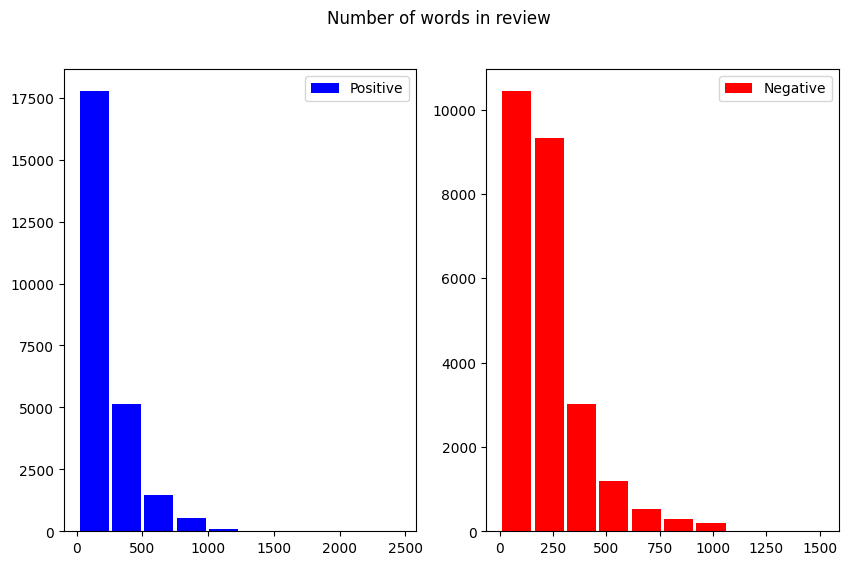

In [125]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(df[df['sentiment'] == 'positive']['word count'], label='Positive', color='blue', rwidth=0.9)
ax[0].legend()
ax[1].hist(df[df['sentiment'] == 'negative']['word count'], label='Negative', color='red', rwidth=0.9)
ax[1].legend()
fig.suptitle("Number of words in review")
plt.show()


<Figure size 500x800 with 0 Axes>

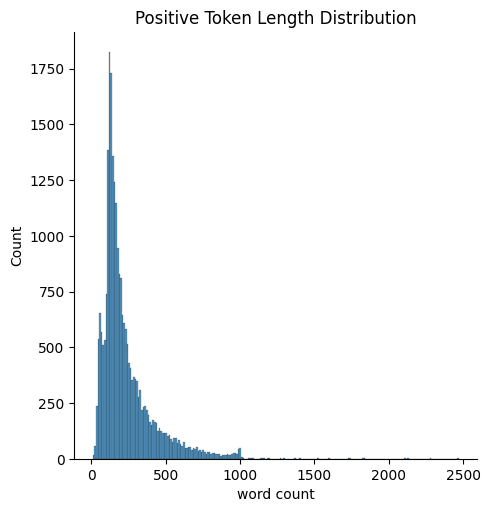

In [126]:
plt.figure(figsize=(5, 8))
sns.displot(df[df["sentiment"] == "positive"], x='word count')
plt.title('Positive Token Length Distribution')
plt.show()

<Figure size 500x800 with 0 Axes>

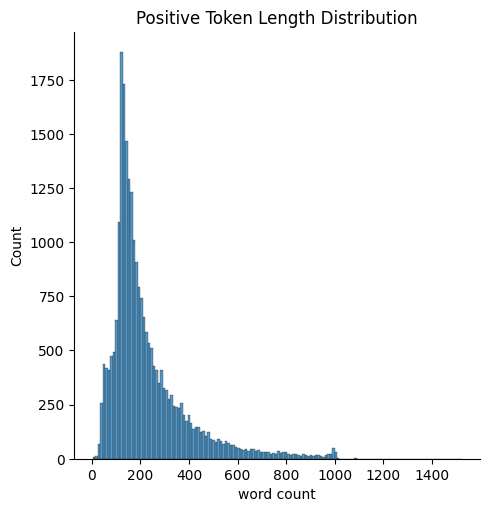

In [127]:
plt.figure(figsize=(5, 8))
sns.displot(df[df["sentiment"] == "negative"], x='word count')
plt.title('Positive Token Length Distribution')
plt.show()

Now we use label encoding for `sentiment` column.

In [128]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["sentiment"])
df.head()

,review,sentiment,word count,label
0,One of the other reviewers has mentioned that ...,positive,307,1
1,A wonderful little production. <br /><br />The...,positive,162,1
2,I thought this was a wonderful way to spend ti...,positive,166,1
3,Basically there's a family where a little boy ...,negative,138,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,1


In [ ]:
pos_reviews = df[df["sentiment"] == "positive"]
neg_reviews = df[df["sentiment"] == "negative"]

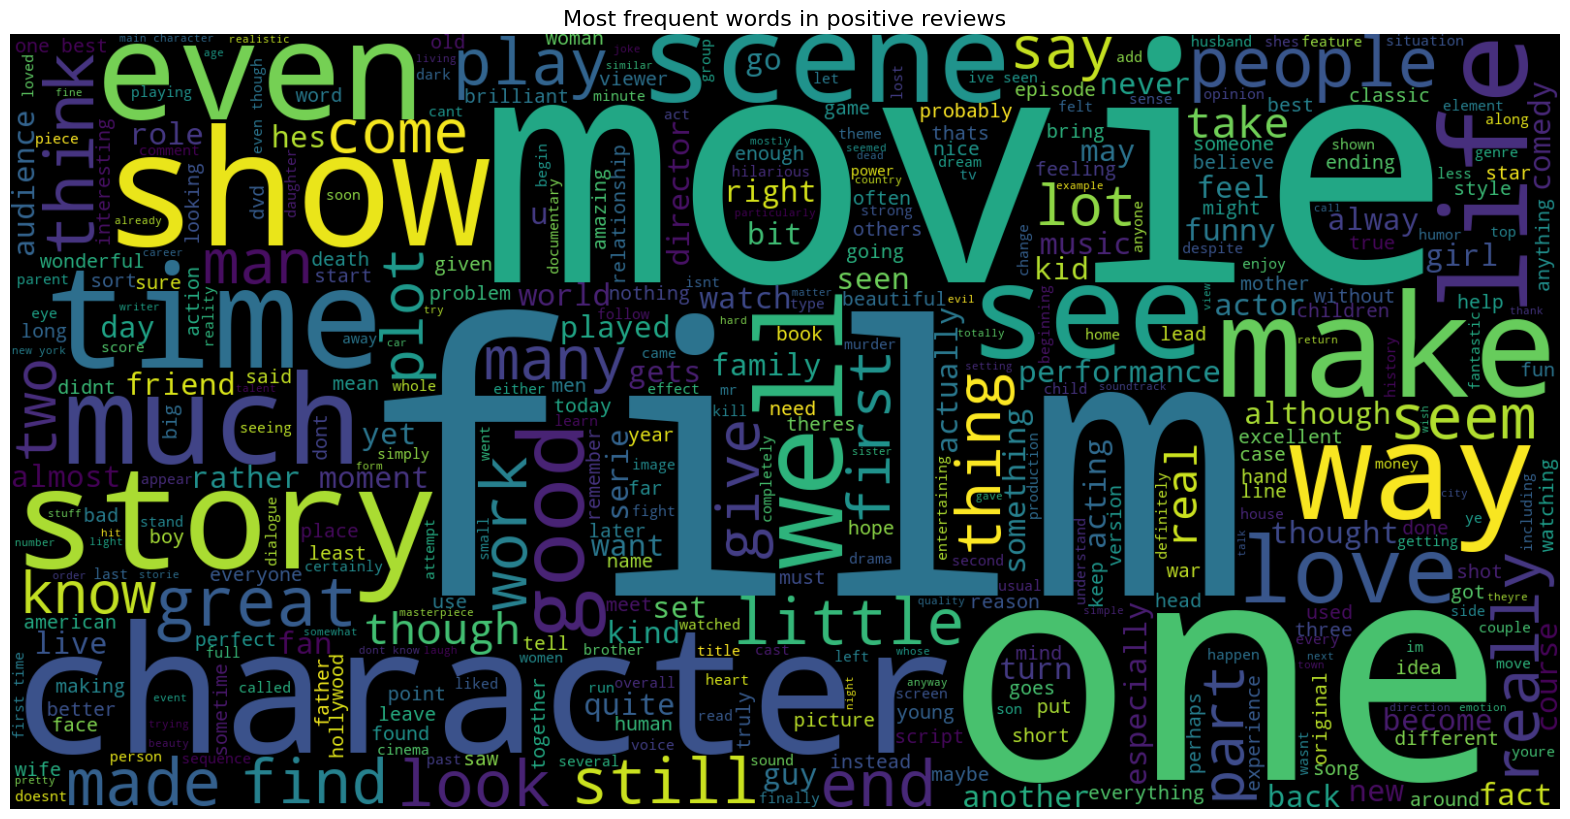

In [ ]:
text = ' '.join([word for word in pos_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=400, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive reviews', fontsize = 16)
plt.show()

In [ ]:
count = Counter()
for text in pos_reviews['review'].values:
    for word in text.split():
        count[word] +=1
pos_words = pd.DataFrame(count.most_common(15))
pos_words.columns = ['word', 'count']
pos_words

,word,count
0,film,39285
1,movie,35830
2,one,25621
3,like,16998
4,good,14281
5,great,12568
6,story,12338
7,see,11814
8,time,11724
9,well,10930


In [ ]:
px.bar(pos_words, x='count', y='word', title='Common words in positive reviews', color='word')

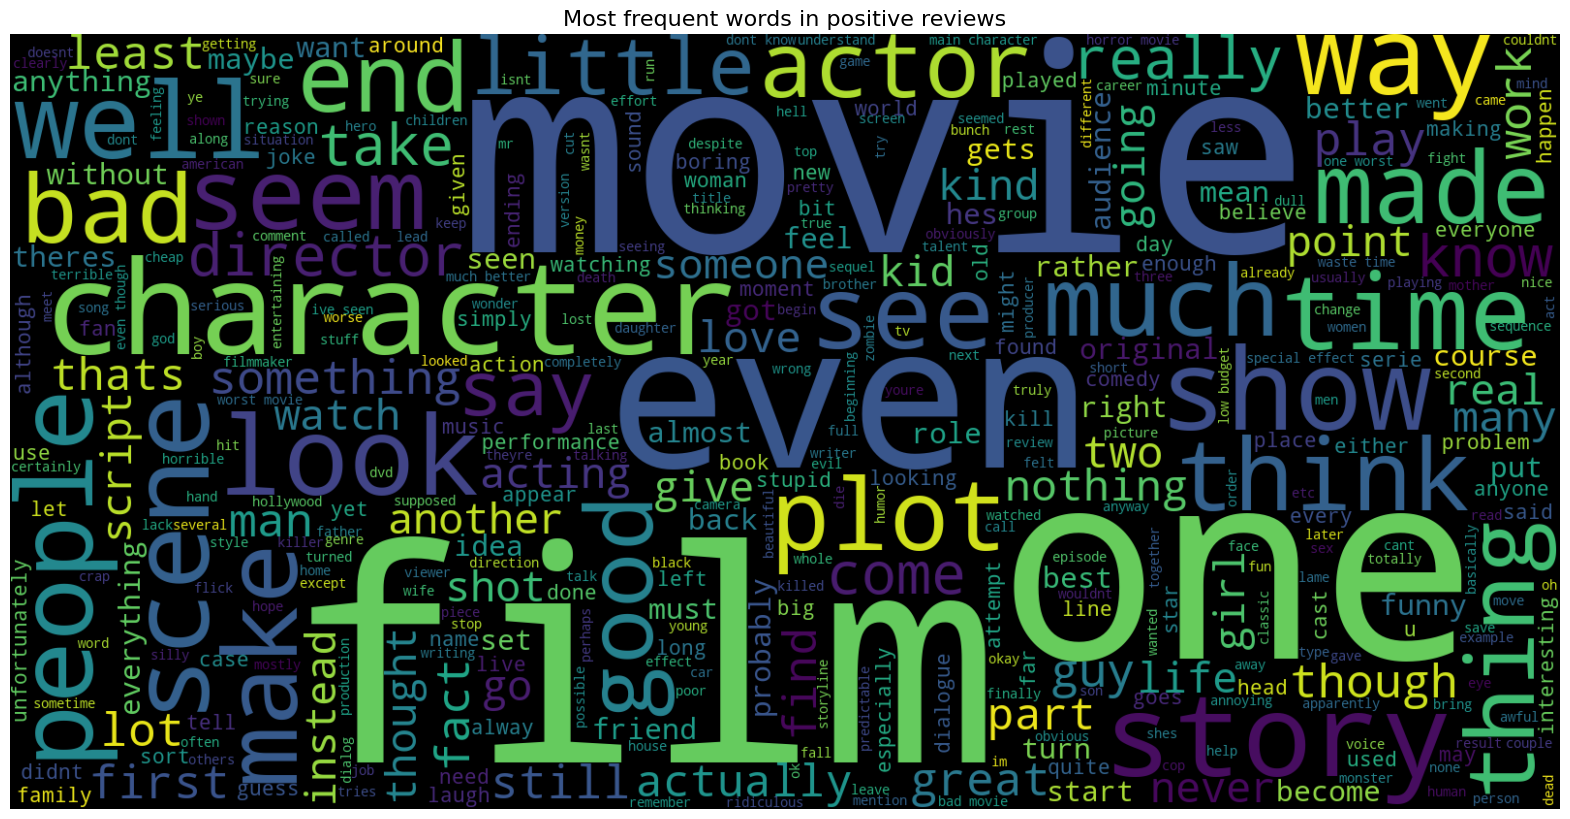

In [ ]:
text = ' '.join([word for word in neg_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=400, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive reviews', fontsize = 16)
plt.show()

In [ ]:
count = Counter()
for text in neg_reviews['review'].values:
    for word in text.split():
        count[word] += 1
neg_words = pd.DataFrame(count.most_common(15))
neg_words.columns = ['word', 'count']
neg_words

,word,count
0,movie,47001
1,film,34651
2,one,24361
3,like,21508
4,even,14759
5,good,13995
6,bad,13903
7,would,13482
8,really,12084
9,time,11349


In [ ]:
px.bar(neg_words, x='count', y='word', title='Common words in negative reviews', color='word')

### Preprocessing

In [129]:
duplicated_count = df.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)
df = df.drop_duplicates('review')
df.info()

Number of duplicate entries:  418
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49582 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      49582 non-null  object
 1   sentiment   49582 non-null  object
 2   word count  49582 non-null  int64 
 3   label       49582 non-null  int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 1.7+ MB


We use regex to delete some useless expressions. the rest of preprocessing will be done later.

In [130]:
def data_processing(text):
    text = text.lower()
    text = re.sub("<br />", "", text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\@w+|\#", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return "".join(text)


df["review"] = df["review"].progress_apply(data_processing)
df.head()

100%|██████████| 49582/49582 [00:03<00:00, 14051.58it/s]


,review,sentiment,word count,label
0,one of the other reviewers has mentioned that ...,positive,307,1
1,a wonderful little production the filming tech...,positive,162,1
2,i thought this was a wonderful way to spend ti...,positive,166,1
3,basically theres a family where a little boy j...,negative,138,0
4,petter matteis love in the time of money is a ...,positive,230,1


Let's see the effect.

Now we split to test and train.

In [131]:
x_train, x_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2)

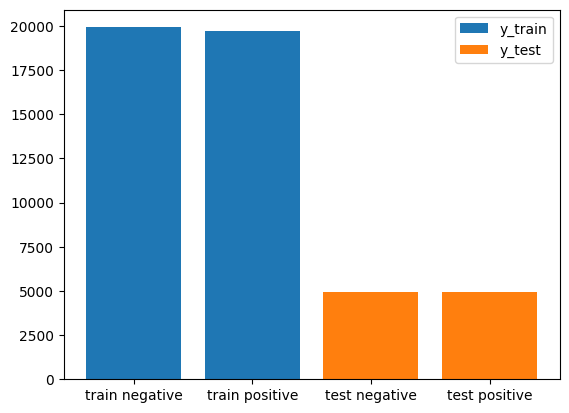

In [132]:
import matplotlib.pyplot as plt

y_train_counts = y_train.value_counts()
y_test_counts = y_test.value_counts()

fig, ax = plt.subplots()
ax.bar(['train negative', 'train positive'], y_train_counts, label='y_train')
ax.bar(['test negative', 'test positive'], y_test_counts, label='y_test')
ax.legend()
plt.show()


### Stemming and Lemmatization
**Stemming** is a technique used in natural language processing and information retrieval to reduce words to their base or root form. The goal of stemming is to group together words that have the same meaning but different forms, such as "run," "running," and "ran." By reducing these words to their common base form, it becomes easier to analyze and compare them.

Stemming algorithms work by removing suffixes from words to produce their root form. For example, the Porter stemming algorithm, one of the most widely used stemming algorithms, removes common suffixes such as "-ing," "-ed," and "-s" to produce the stem of a word. So, the words "running," "ran," and "runs" would all be reduced to the stem "run."

**Lemmatization** is another technique used in natural language processing to reduce words to their base or dictionary form, known as a lemma. Unlike stemming, which simply removes suffixes from words, lemmatization takes into account the context and part of speech of the word to produce a more accurate base form.

For example, the word "better" can be reduced to the stem "bet" using stemming, but lemmatization would recognize that "better" is the comparative form of "good" and reduce it to the lemma "good." Similarly, the word "mice" would be reduced to "mouse" using lemmatization, whereas stemming would produce "mic."

Lemmatization is a more complex process than stemming, as it requires knowledge of the language's grammar and syntax to accurately determine the base form of a word. However, it can produce more accurate results than stemming, especially in applications where precise language analysis is required, such as in machine translation or sentiment analysis.

### TF-IDF
TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a statistical measure used to evaluate the importance of a word in a document or a corpus of documents. 

The TF part of the formula calculates the frequency of a word in a document. It is calculated by dividing the number of times a word appears in a document by the total number of words in the document. This gives a measure of how often a word appears in a document.

The IDF part of the formula calculates the importance of a word in the corpus. It is calculated by dividing the total number of documents in the corpus by the number of documents that contain the word. This gives a measure of how common or rare a word is in the corpus.

The TF-IDF score is then calculated by multiplying the TF and IDF scores together. This gives a measure of how important a word is in a document, taking into account both its frequency in the document and its rarity in the corpus.

The TF-IDF score is commonly used in information retrieval and text mining applications, such as search engines and document classification. It helps to identify the most relevant documents for a given query by giving higher scores to documents that contain the query terms with high TF-IDF scores.

In [ ]:
class LemmaTokenizer:
    ignore_tokens = [",", ".", ";", ":", '"', "``", "''", "`"]

    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if t not in self.ignore_tokens
        ]


tokenizer = LemmaTokenizer()
token_stop = tokenizer(" ".join(stopwords))

vectorizer = TfidfVectorizer(
    max_features=3000, stop_words=token_stop, tokenizer=tokenizer
)
vectorizer.fit(x_train.values)
X_train_vec = vectorizer.transform(x_train.values)
X_test_vec = vectorizer.transform(x_test.values)

Check if all the features are between 0 and 1.

In [136]:
(((X_train_vec.min() >= 0) and (X_train_vec.max() <= 1)) and ((X_test_vec.min() >= 0) and (X_test_vec.max() <= 1)))

True

## 3.1. MLP in tensorflow

In [ ]:
model = models.Sequential()
NEURONS = 128
model.add(layers.Dense(NEURONS, activation='relu', input_shape=(3000,)))
model.add(layers.Dense(NEURONS, activation='relu'))
model.add(layers.Dense(NEURONS, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.SGD(lr=0.1)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


## 3.2. MLP in torch

In [ ]:
# y = Wx + b
class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        # YOUR CODE HERE
        raise NotImplementedError()

    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()
        
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        
    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [ ]:
# Define your dataloader here (specify your batch_size)
# Use:
from torch.utils.data import TensorDataset, DataLoader
# Note that you should transform your X, y to torch.Tensor

In [ ]:
# define your network with nn.Sequential
# use MyLinear_mod, MyReLU_mod and nn.Sigmoid (from pytorch)

# YOUR CODE HERE

raise NotImplementedError()

NotImplementedError: 

In [ ]:
from torch import optim

optimizer = optim.SGD(yourTorchNetwork.parameters(), lr=...)

losses = []
criterion = nn.BCELoss()
epochs = ...
for epoch in range(epochs):
    # You can print epoch No. and train/test accuracy here (after each epoch)
    for batch in yourTrainDataloader:
        # do a forward pass on the batch
        # YOUR CODE HERE
        raise NotImplementedError()

        # compute the loss according to your output and the label
        # YOUR CODE HERE
        raise NotImplementedError()

        # zero the gradients
        # YOUR CODE HERE
        raise NotImplementedError()

        # backward pass
        # YOUR CODE HERE
        raise NotImplementedError()

        # gradient step
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
plt.plot(losses)

In [ ]:
# print the classification_report